In this notebook, we use a technique called `Transfer Learning` which allows us to utilize an already trained network to help solve a similar problem to the one it was originally trained to solve.


In [6]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Dataset

We'll use the `Horse or Human dataset`, which contains images of horses and humans. 

Downloading the `training` and `validation` sets:

In [7]:
# Getting the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Getting the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

This dataset already has an structure that is compatible with Keras' `flow_from_directory` so we don't need to move the images into subdirectories. We'll still save the paths of the images so we can use them later on:

In [8]:
# Defining the training and validation base directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Checking the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



We now take a look at a sample image of each one of the classes:

Sample horse image:


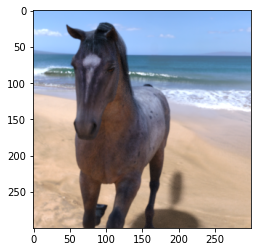


Sample human image:


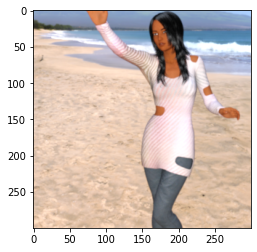

In [9]:
print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

In [10]:
# Loading the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Converting the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


The sample image has a resolution of 300x300 and the last dimension is used for each one of the RGB channels to represent color.

## Training and Validation Generators

Now that we know the images you are dealing with, we'll code the generators that will fed these images to our Network - `train_val_generators` function below does this.

**Important Note:** The images have a resolution of 300x300 but the `flow_from_directory` method allows us to set a target resolution. In this case, we **set a `target_size` of (150, 150)**. This will heavily lower the number of trainable parameters in the final network, yielding much quicker training times without compromising the accuracy!

In [12]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
      Creates the training and validation data generators
  
    Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images
    
    Returns:
        train_generator, validation_generator: tuple containing the generators
    """

    # Instantiating the ImageDataGenerator class 
    # Normalizing pixel values and setting arguments to augment the images 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=45,
                                     height_shift_range=0.2,
                                     width_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)

    # Passing in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiating the ImageDataGenerator class (don't forget to set the rescale argument)
    # The validation data isn't augmented
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Passing in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    
    return train_generator, validation_generator


In [13]:
# Testing our generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Transfer learning - Create the pre-trained model

We download the `inception V3` weights into the `/tmp/` directory:

In [14]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-05-20 12:05:51--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 142.251.45.16, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   113MB/s    in 0.7s    

2022-05-20 12:05:52 (113 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Now we load the `InceptionV3` model and save the path to the weights we just downloaded:

In [15]:
# Importing the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Creating an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [16]:
def create_pre_trained_model(local_weights_file):
    """
    Initializes an InceptionV3 model.

    Args:
        local_weights_file (string): path pointing to a pretrained weights H5 file

    Returns:
        pre_trained_model: the initialized InceptionV3 model
    """
  
    pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

    pre_trained_model.load_weights(local_weights_file)

    # Making all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model
  

Model Summary

In [17]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

Making sure that all the layers in the model were set to be non-trainable, you can also run the cell below:

In [18]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


## Creating callbacks for later


In [21]:
# Defining a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

## Pipelining the pre-trained model with our own model

Now that the pre-trained model is ready, we need to "glue" it to our own model to solve the task at hand.

For this we need the last output of the pre-trained model, since this will be the input for our own. 


In [22]:
def output_of_last_layer(pre_trained_model):
    """
    Gets the last layer output of a model

    Args:
        pre_trained_model (tf.keras Model): model to get the last layer output from

    Returns:
        last_output: output of the model's last layer 
    """
    last_desired_layer =pre_trained_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)

    return last_output


Sanity check:

In [23]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


Now we'll create the final model by adding some additional layers on top of the pre-trained model -  `create_final_model` function below does this

In [25]:

def create_final_model(pre_trained_model, last_output):
    """
    Appends a custom model to a pre-trained model
  
    Args:
        pre_trained_model (tf.keras Model): model that will accept the train/test inputs
        last_output (tensor): last layer output of the pre-trained model
    
    Returns:
        model: the combined model
    """
    # Flattening the output layer to 1 dimension
    x = layers.Flatten()(last_output)

    # Adding a fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Adding a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)  
    # Adding a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)        

    # Creating the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)

    # Compiling the model
    model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
    return model


In [26]:
# Saving our model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


We now train the model:

In [29]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
33/33 - 26s - loss: 0.2341 - accuracy: 0.9318 - val_loss: 0.0128 - val_accuracy: 0.9961 - 26s/epoch - 783ms/step
Epoch 2/100
33/33 - 11s - loss: 0.0420 - accuracy: 0.9854 - val_loss: 0.0216 - val_accuracy: 0.9883 - 11s/epoch - 342ms/step
Epoch 3/100
33/33 - 11s - loss: 0.0224 - accuracy: 0.9922 - val_loss: 0.1232 - val_accuracy: 0.9648 - 11s/epoch - 339ms/step
Epoch 4/100
33/33 - 11s - loss: 0.0108 - accuracy: 0.9951 - val_loss: 4.2468e-04 - val_accuracy: 1.0000 - 11s/epoch - 343ms/step
Epoch 5/100
33/33 - 11s - loss: 0.0350 - accuracy: 0.9903 - val_loss: 7.3244e-04 - val_accuracy: 1.0000 - 11s/epoch - 335ms/step
Epoch 6/100
33/33 - 11s - loss: 0.0146 - accuracy: 0.9951 - val_loss: 8.3537e-04 - val_accuracy: 1.0000 - 11s/epoch - 334ms/step
Epoch 7/100
33/33 - 11s - loss: 0.0246 - accuracy: 0.9942 - val_loss: 0.0026 - val_accuracy: 1.0000 - 11s/epoch - 339ms/step
Epoch 8/100
33/33 - 11s - loss: 0.0041 - accuracy: 0.9981 - val_loss: 0.0166 - val_accuracy: 0.9922 - 11s/epoch -

Now we take a quick look at the training and validation accuracies for each epoch of training:

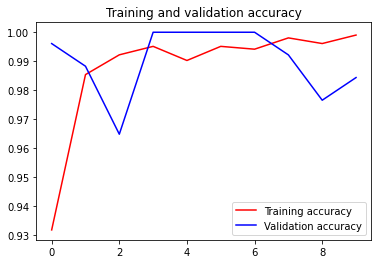

<Figure size 432x288 with 0 Axes>

In [30]:
# Plotting the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

References:

[deeplearning.ai - TF](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/home/welcome)